## init

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms

import sys
sys.path.insert(0, '/root/git/hetcattoolbox')

import seaborn as sns
import pandas as pd
import numpy as np

In [56]:
from autoadsorbate.string_utils import _example_config, _show_ussage, construct_smiles, xx_get_special_symbols
from autoadsorbate.autoadsorbate import Fragment, Surface
from autoadsorbate.Surf import conformer_to_site
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import plotly.express as px
from ase.build.tools import sort as sort_atoms
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O

## aads MACE relaxed intermediates

In [ ]:
# # all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
# all_files = glob('./prep/relax/MACE*.xyz')
# len(all_files)

# rdf, relaxed_traj = read_relax_dir(all_files)
# _ = rdf.pop('site')
# rdf['origin'] = ['aads' for _ in rdf['uid']]

In [61]:
# from mace.calculators import mace_mp

# ref_atoms = relaxed_traj[0].copy()[[atom.index for atom in relaxed_traj[0] if atom.symbol == 'Cu']]
# calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
# ref_atoms.set_calculator(calc)
# parent_en = ref_atoms.get_potential_energy()

# ref_dict={
#     'C' : 0,
#     'O' : 0,
#     'H' : 0
# }

# # parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

# xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

### process df function

In [103]:
import chemiscope

def filter_xdf(xdf, relaxed_traj):
    _xdf = xdf[
            (xdf['energy']>-100)
            & (xdf['energy']< 40)
            & (xdf.bond_change == 0)
            & xdf.backbone_formula.isin(['C','C2','C2O','CO','CO2','O', 'O2'])
            # & (xdf.origin == 'aads')
            # & (xdf.H < 7)
    ]

    if 'array_from_ocp' in _xdf.columns:
        _xdf.pop('array_from_ocp')

    C_bonds_O = []
    for i in _xdf.traj_index.values:
        sx = count_C_next_to_O(relaxed_traj[i])
        C_bonds_O.append(sx)
    _xdf['C_bonds_O'] = C_bonds_O

    backbone = []
    for i in _xdf.index.values:
        f = _xdf.backbone_formula.loc[i]
        if f == 'C2O' and (_xdf.loc[i]['C_bonds_O'] == 2):
            f = 'COC'
        backbone.append(f)
    _xdf['backbone'] = backbone

    #set H_max for each backbone manually
    map_H_max = {'C': 3, 'C2': 6, 'C2O': 6, 'CO': 4, 'CO2': 4, 'O': 2, 'O2': 2}
    map_backbone = dict([(v,i) for i, v in enumerate(sorted(list(_xdf.backbone.unique())))])

    #make plot float for plotting energy verus multiple in 2d
    map_origin = {'aads':0, 'ocp':1}
    _xdf['plot_float'] = [
        map_backbone[_xdf.backbone.values[i]] + _xdf.H.values[i]/20  + map_origin[_xdf.origin.values[i]]*0.5 for i in range(len(_xdf))
    ] 
    _xdf['plot_float'] = _xdf['plot_float'] * 0.2
    _xdf['H_max'] = [map_H_max[_xdf.backbone_formula.values[i]] for i in range(len(_xdf))]
    _xdf = _xdf[_xdf['H'] <= _xdf['H_max']]

    #make reference energy
    _xdf['calibrate_keys'] = _xdf.backbone + '-H' + _xdf.H.astype(int).astype(str)

    set_zero_dict = {}

    for k, v in dict(_xdf.groupby(['backbone','H']).energy.min()).items():
        key = f'{k[0]}-H{int(k[1])}'
        set_zero_dict[key] = v

    group_ref_energy = []
    for k in _xdf['calibrate_keys']:
        group_ref_energy.append(set_zero_dict[k])

    _xdf['group_ref_energy'] = group_ref_energy
    _xdf['energy_calibrated'] = _xdf['energy'] - _xdf['group_ref_energy']

    print(f'remaining values in DF: {len(_xdf)}')
    return _xdf

def center_fragment_in_cell(atoms, fragment_inds):
    a = atoms.copy()
    fragment = atoms.copy()[[atom.index for atom in atoms if atoms.arrays['fragments'][atom.index] in fragment_inds]]
    fragment_center = fragment.get_center_of_mass()
    fragment_center[2] = 0
    a.positions += - fragment_center + (a.cell[0] + a.cell[1]) / 2
    a.wrap()
    return a

### chemiscope

In [173]:
xdf = pd.read_csv('relaxed_traj.csv')
relaxed_traj = read('relaxed_traj.xyz', index=':')

In [174]:
_xdf = filter_xdf(xdf, relaxed_traj)

/tmp/ipykernel_47923/376942454.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O


remaining values in DF: 13370


/tmp/ipykernel_47923/376942454.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/tmp/ipykernel_47923/376942454.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['plot_float'] = [
/tmp/ipykernel_47923/376942454.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [175]:
len(_xdf.smiles.unique())

1425

In [176]:
len(_xdf.smiles.unique())

1425

In [177]:
# chemiscope.show(
#     frames=[relaxed_traj[i] for i in _xdf.traj_index.values],
#     properties=_xdf.to_dict(orient='list'),
#     mode='default',
# )

In [178]:
chemiscope.write_input(
    frames=[center_fragment_in_cell(relaxed_traj[i], fragment_inds=[1]) for i in _xdf.traj_index.values],
    properties=_xdf.to_dict(orient='list'),
    path='chemiscope_input.json'
    # mode='default',
)

/root/venvs/mace_env/lib/python3.12/site-packages/chemiscope/structures/__init__.py:93: UserWarning: the following structure properties are only defined for a subset of frames: ['C', 'H', 'O']; they will be ignored
  return _ase_list_structure_properties(frames)


### plot atoms

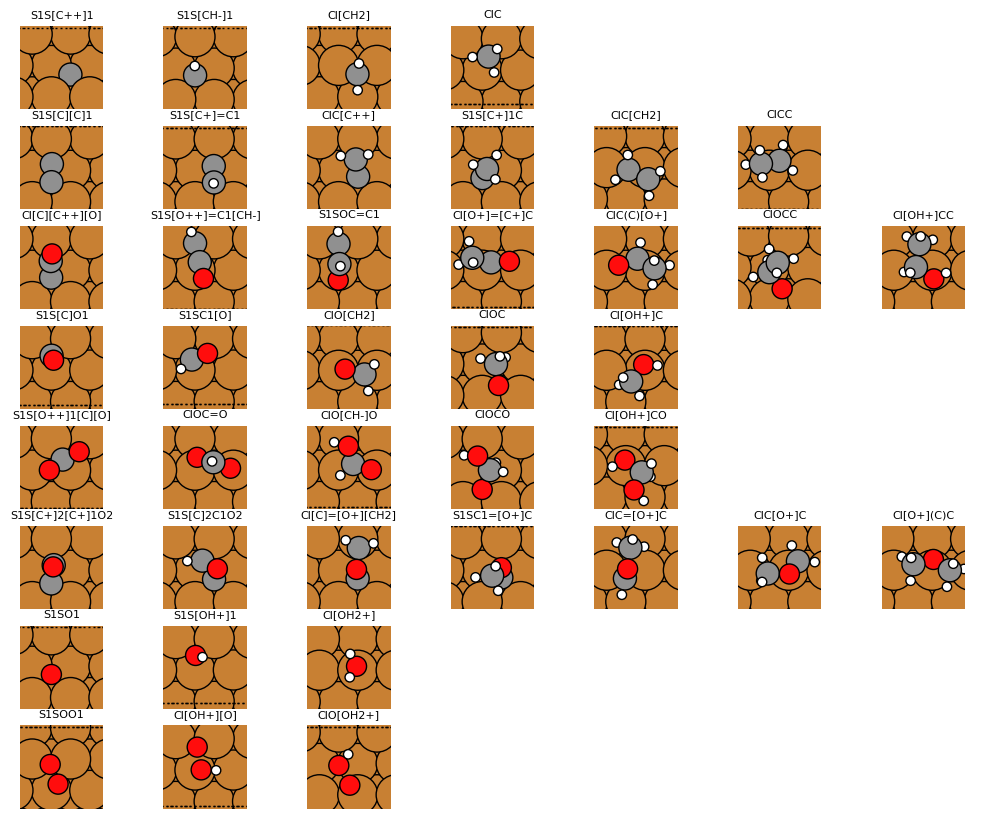

In [250]:
def plot_most_stable(_xdf, relaxed_traj):
    fig, axs = plt.subplots(
        ncols=len(_xdf.H.unique()),
        nrows=len(_xdf.backbone.unique()),
        figsize=[10,8]
    )

    _xdf = _xdf.sort_values(by=['H', 'backbone'])

    view_atoms = []

    for i, backbone in enumerate(_xdf.backbone.unique()):
        for j, H in enumerate(_xdf.H.unique()):

            ax = axs[i,j]
            
            df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
            # df_slice.sort_values(by=['energy', 'backbone', 'H'],ascending=True)
            df_slice=df_slice[df_slice.energy==df_slice.energy.min()]
            
            if len(df_slice) > 0:
                e = np.round(df_slice.iloc[0].energy,2)
                origin = df_slice.iloc[0].origin
                traj_index = df_slice.iloc[0].traj_index
                
                atoms = relaxed_traj[traj_index].copy()
                shift = - atoms[[atom.index for atom in atoms if atoms.arrays['fragments'][atom.index] == 1]].get_center_of_mass() + atoms.cell[0]*.5+ atoms.cell[1]*.5
                atoms.positions += shift
                atoms.wrap()
                
                plot_atoms(atoms, ax, rotation=('0x,0y,0z'), show_unit_cell=2)
                # ax.set_title(atoms.info['adsorbate_info']['smiles'], size=8)
                ax.set_title(df_slice.smiles.iloc[0], size=8)
                
            ax.set_axis_off()
            ax.set_xlim(1, 6)
            ax.set_ylim(2, 7)
            # x = cell[0][0] + cell[1][0]
            # y = cell[0][1] + cell[1][1]
            ax.set_xlim(2, 7.5)
            ax.set_ylim(1, 6.5)
            
            view_atoms.append(atoms)

    # fig.set_layout_engine(layout='tight')
    plt.tight_layout(pad=0.01, w_pad=0.4, h_pad=0.01)

plot_most_stable(_xdf, relaxed_traj)

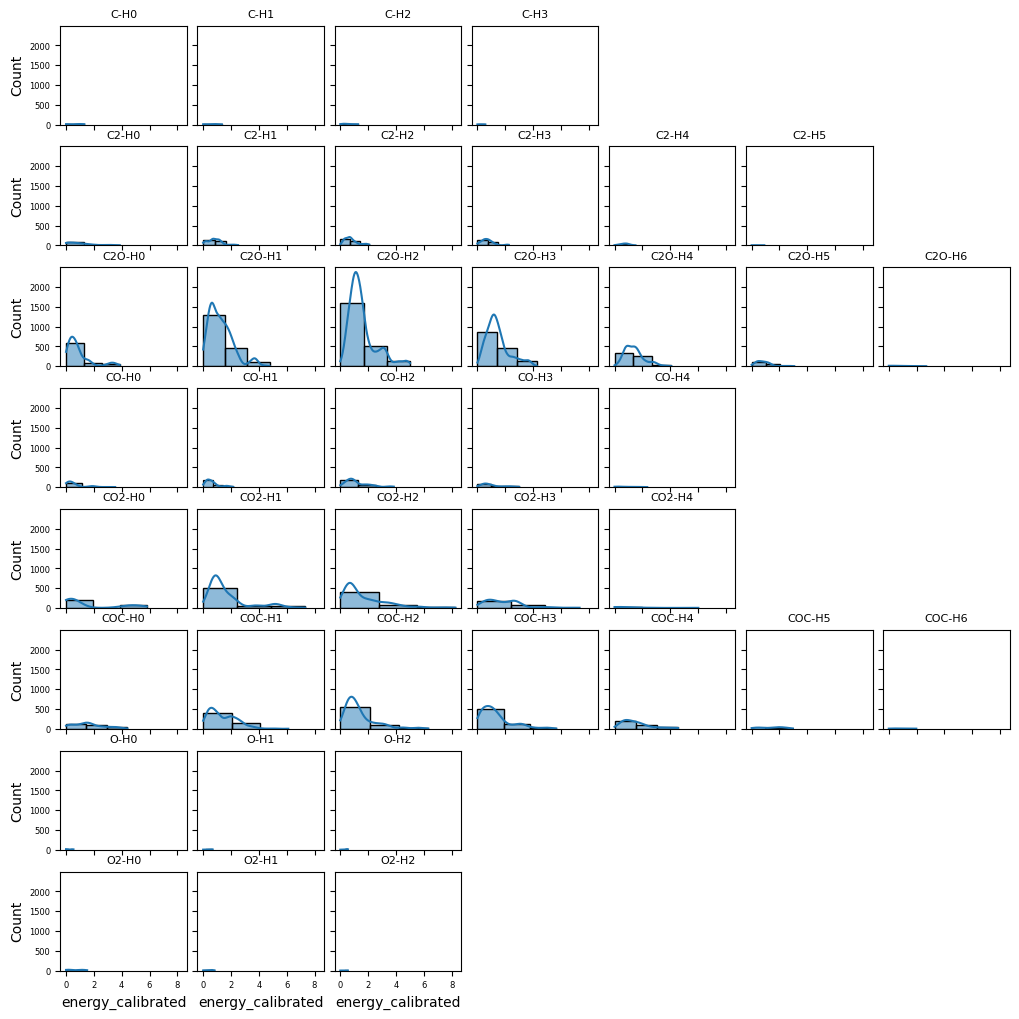

In [249]:
def make_hist_plot(_xdf):
    fig, axs = plt.subplots(
        ncols=len(_xdf.H.unique()),
        nrows=len(_xdf.backbone.unique()),
        figsize=[10,10],
        sharex=True,
        sharey=True,
    )

    _xdf = _xdf.sort_values(by=['H', 'backbone'], ascending=True)

    view_atoms = []

    for i, backbone in enumerate(_xdf.backbone.unique()):
        for j, H in enumerate(_xdf.H.unique()):

            ax = axs[i,j]
            
            df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
            # df_slice.sort_values(by=['energy', 'backbone', 'H'],ascending=True)
            # df_slice=df_slice[df_slice.energy==df_slice.energy.min()]
            
            if len(df_slice) > 0:
                sns.histplot(df_slice, x='energy_calibrated', ax=ax, bins=3, kde=True)
                ax.set_title(df_slice.calibrate_keys.values[0], size=8)
                # ax.set_ylim(0, 150)
                ax.tick_params(axis='x', labelsize=6)
                ax.tick_params(axis='y', labelsize=6)

            else:
                ax.set_axis_off()
            # ax.set_xlim(1, 6)
            
            # x = cell[0][0] + cell[1][0]
            # y = cell[0][1] + cell[1][1]
            # ax.set_xlim(x+2, x+9)
            # ax.set_ylim(y-3, y+3)
            
            view_atoms.append(atoms)

    # fig.set_layout_engine(layout='tight')
    plt.tight_layout(pad=0.01, w_pad=0.4, h_pad=0.01)

make_hist_plot(_xdf)

In [251]:
energy_descriptor_from_slice?

Signature:
energy_descriptor_from_slice(
    df_slice,
    column='energy_calibrated',
    std=0.05,
    e_min='auto',
    e_max='auto',
    resolution='default',
    normalize=True,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_47923/1096785260.py
Type:      function

In [232]:
# sns.stripplot(
#     data=_xdf, x="total_bill", y="day", hue="time",
#     jitter=False, s=20, marker="D", linewidth=1, alpha=.1,
# )

In [ ]:
np.abs(-0.51) % 0.5 < 0.011

True

## paper prep

In [107]:
# all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
all_files = glob('./relax_*/MACE*.xyz')
len(all_files)

rdf, relaxed_traj = read_relax_dir(all_files)
_ = rdf.pop('site')
rdf['origin'] = ['aads' for _ in rdf['uid']]

In [110]:
from mace.calculators import mace_mp

atoms = relaxed_traj[0].copy()
ref_atoms = atoms[[atom.index for atom in relaxed_traj[0] if atoms.arrays['fragments'][atom.index] == 0]]
calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
ref_atoms.set_calculator(calc)
parent_en = ref_atoms.get_potential_energy()

ref_dict={
    'C' : 0,
    'O' : 0,
    'H' : 0
}

# parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_47923/2181362744.py:6: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


In [112]:
_xdf = filter_xdf(xdf, relaxed_traj)

remaining values in DF: 172


/tmp/ipykernel_47923/376942454.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O
/tmp/ipykernel_47923/376942454.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/tmp/ipykernel_47923/376942454.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [115]:
len(_xdf.energy_calibrated.values)

172

In [ ]:
energy_range = np.linspace(, 10, 100)

In [258]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)/100

def get_gaussian_vector(e, std = 0.05, e_min = -0.2, e_max = 3, resolution=0.01, normalize=False):
    energy_range = np.linspace(e_min, e_max, int((e_max-e_min)/resolution))
    energy_values = np.zeros(len(energy_range))
    for i, energy in enumerate(energy_range):
        energy_values[i] = gaussian(energy, e, std)
    
    if normalize:
        energy_values = energy_values / np.sum(energy_values)
    
    return energy_range, energy_values

def get_gaussian_vectors(energies, std = 0.05, e_min = -0.2, e_max = 3, resolution=0.01, normalize=True):
    energy_range = np.linspace(e_min, e_max, int((e_max-e_min)/resolution))
    energy_values = np.zeros(len(energy_range))
    for e in energies:
        energy_values += get_gaussian_vector(e, std = std, e_min = e_min, e_max = e_max, resolution=resolution)[1]
    
    if normalize:
        energy_values = energy_values / np.sum(energy_values)

    return energy_range, energy_values

def energy_descriptor_from_slice(df_slice, column='energy_calibrated', std = 0.05,
                                 e_min = 'auto', e_max = 'auto', resolution='auto', normalize=True):
    
    if e_min == 'auto':
        e_min = df_slice[column].min() - 5*std

    if e_max == 'auto':
        e_max = df_slice[column].max() + 5*std
    
    if resolution == 'auto':
        resolution = std / 7

    energy_range, energy_values = get_gaussian_vectors(df_slice[column].values, std = std, e_min = e_min, e_max = e_max, resolution=resolution, normalize=normalize)

    return energy_range, energy_values



In [171]:
heat_map = []
std = 0.05

for i, backbone in enumerate(_xdf.backbone.unique()):
    for j, H in enumerate(_xdf.H.unique()):
        df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
        if len(df_slice) > 0:
            v = energy_descriptor_from_slice(df_slice, column='energy_calibrated', std=std, e_min=_xdf.energy_calibrated.min()-5*std, e_max=_xdf.energy_calibrated.max()+5*std)
            heat_map.append(v[1])           

<Axes: >

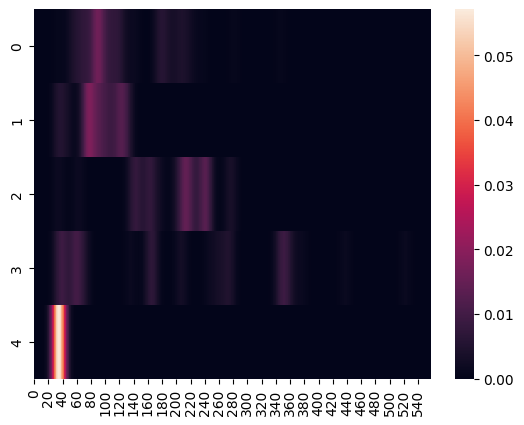

In [172]:
sns.heatmap(heat_map)